In [4]:
import numpy as np
from matplotlib import pyplot as plt
from ase import Atoms
from ase.visualize.plot import plot_atoms
import sys
sys.path.append("../../Functions")
from structure_generator import (
    construction_periodic,
    set_dopants,
    construct_amorphous)
from GS_waves import select_freq_range
from abtem.waves import PlaneWave
from Column_matching import (
    select_column,
    match_parameters_Bessel,
    propagation_Bessel,
    inv_Bessel,
    Bessel_transform
    )
import Generate_structure
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from lmfit import Model
from circle_fit import least_squares_circle

In [5]:
def Gaussian_function(k, a1_re, a1_im, b1_re, b1_im, a2_re, a2_im, b2_re, b2_im, c_re, c_im):
    theta1 = -b1_im * k**2
    theta2 = -b2_im * k**2
    y_re = c_re \
        + np.exp(-b1_re * k**2) * (a1_re*np.cos(theta1) - a1_im*np.sin(theta1))\
        + np.exp(-b2_re * k**2) * (a2_re*np.cos(theta2) - a2_im*np.sin(theta2))
    y_im = c_im \
        + np.exp(-b1_re * k**2) * (a1_re*np.sin(theta1) + a1_im*np.cos(theta1))\
        + np.exp(-b2_re * k**2) * (a2_re*np.sin(theta2) + a2_im*np.cos(theta2))
    return y_re + 1j*y_im

def Gaussian_in_focus(k, a1_re, a1_im, b1, a2_re, a2_im, b2, c_re, c_im):
    y_re = c_re + a1_re * np.exp(-b1 * k**2) + a2_re * np.exp(-b2 * k**2)
    y_im = c_im + a1_im * np.exp(-b1 * k**2) + a2_im * np.exp(-b2 * k**2)
    return y_re + 1j*y_im

def Gaussian_fitting(profile, freq_data, freq_range):
    index_sel = np.where(np.logical_and(freq_data>=freq_range[0],
                                        freq_data<=freq_range[1]))
    #Step 1: fit line for the complex component
    fit_x = freq_data[index_sel]; fit_y = profile[index_sel]
    peak_complex = fit_y[0]
    re = np.real(fit_y).ravel().reshape(-1, 1)
    im = np.imag(fit_y).ravel()
    res = LinearRegression().fit(re, im)
    slope = res.coef_[0]; intercept = res.intercept_
    #Step 2: fit Gaussian function for the line
    X = (fit_x**2).reshape(-1, 1)
    y = np.log(np.abs(fit_y-intercept))
    res = LinearRegression().fit(X, y); k_init = -res.coef_[0]
    model = Model(Gaussian_function)
    params = model.make_params(a1_re=np.real(peak_complex),
                               a1_im=np.imag(peak_complex)-intercept,
                               b1_re=0, b1_im=intercept,
                               a2_re=0, a2_im=0, b2_re=0, b2_im=0,
                               c_re=k_init, c_im=0,)
    result = model.fit(fit_y, params, k=fit_x)
    return result

100%|██████████| 78/78 [00:11<00:00,  6.82it/s]


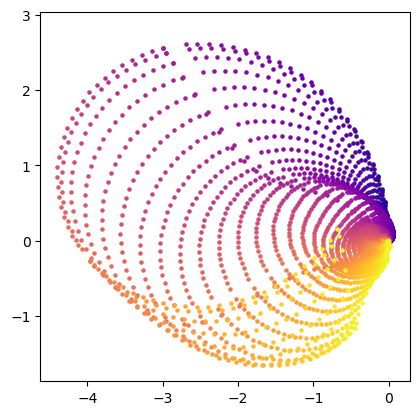

In [6]:
#Parameters to set
gmin = 0; gmax = 2; sampling = 0.0656015; energy = 300e3
a = 4.05; length = 50
#Results from isolated column
max_thickness = 80
thickness_range = np.arange(2, max_thickness, 1)
theta = np.linspace(0, 2*np.pi, 100)
cmap = plt.get_cmap("plasma")
slope_rec = []
coeff_rec = []
error_rec = []
fitted_rec = []
for thickness in tqdm(thickness_range):
    structure_1 = Generate_structure.generate_column("Al", thickness, a, a)
#    structure_1 = Generate_structure.generate_periodic_fcc("Al", a, 1, 1, thickness)
    exitwave_1 = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure_1).array),
                            gmin, gmax, sampling)
#    m, n = exitwave_1.shape
#    exitwave_1 = exitwave_1[m//4:3*m//4, n//4:3*n//4]
    results, components = Bessel_transform(exitwave_1-1, sampling, gmin+0.01, gmax, length, x0=sampling/2, y0=sampling/2)
    krange = np.linspace(gmin+0.01, gmax, length)
    index_sel = np.where(np.logical_and(krange>=0.01,
                                        krange<=1))
    #Step 1: fit line for the complex component
    re = np.real(results[index_sel]).ravel().reshape(-1, 1)
    im = np.imag(results[index_sel]).ravel()
    res = LinearRegression().fit(re, im)
    slope_rec.append(res.coef_[0])
    #Step 2: fit for Gaussian function
    result = Gaussian_fitting(results,
                              krange,
                              [0.01, 1])
    coeff_rec.append(np.array(list(result.best_values.values())))
    error = np.linalg.norm(results[index_sel] - result.best_fit)
    error_rec.append(error)
    results_fit = result.best_fit
    m, n = components.shape
    coeffs = np.array(list(result.best_values.values()))
    a1_re, a1_im, b1_re, b1_im, a2_re, a2_im, b2_re, b2_im, c_re, c_im = coeffs
    bg_re = coeffs[-2]; bg_im = coeffs[-1]; bg = bg_re + 1j*bg_im
    #results_fit = Gaussian_in_focus(krange, a1_re, a1_im, b1_re, a2_re, a2_im, b2_re, c_re, c_im) - bg
    results_fit = Gaussian_function(krange, *coeffs) - bg
    #plt.scatter(np.real(results_fit), np.imag(results_fit), s=5, color=cmap(thickness/max_thickness))
    plt.scatter(np.real(results), np.imag(results), s=5, color=cmap(thickness/max_thickness))
    components_fit = inv_Bessel(results_fit, m, n, sampling, gmin+0.01, gmax, length, x0=sampling/2, y0=sampling/2)
    index = np.unravel_index(np.argmax(np.abs(components_fit)), components_fit.shape)
    peak_fitted = components_fit[index]
    fitted_rec.append(peak_fitted)
    #plt.scatter(np.real(peak_fitted), np.imag(peak_fitted), s=5, color=cmap(thickness/max_thickness))
    #plt.scatter(np.real(components_fit), np.imag(components_fit), s=5, color=cmap(thickness/max_thickness))
    #plt.scatter(np.real(results), np.imag(results), color=cmap(thickness/max_thickness), s=5)
    #plt.plot(np.real(results_fit), np.imag(results_fit), color=cmap(thickness/max_thickness), linewidth=1)
slope_rec = np.array(slope_rec)
coeff_rec = np.array(coeff_rec)
error_rec = np.array(error_rec)
fitted_rec = np.array(fitted_rec)
#plt.plot(thickness_range, coeff_rec)
#plt.xlim([0, 0.5])
#plt.scatter(np.real(fitted_rec), np.imag(fitted_rec), color='b', s=10)
coordinates_to_fit = np.vstack((np.real(fitted_rec), np.imag(fitted_rec))).T
xc, yc, r, sigma = least_squares_circle(coordinates_to_fit)
#plt.plot(xc + r*np.cos(theta), yc + r*np.sin(theta), color='b')
plt.axis("square")
plt.show()

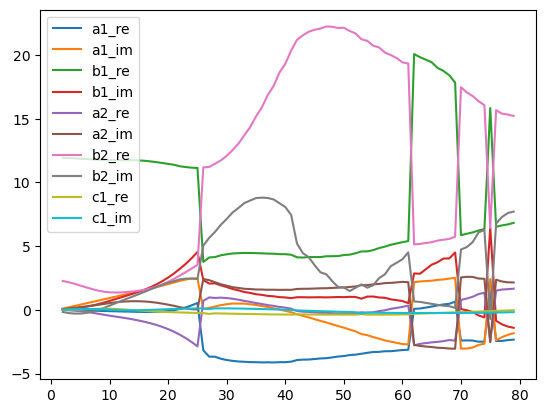

In [7]:
list = ["a1_re", "a1_im", "b1_re", "b1_im", 
        "a2_re", "a2_im", "b2_re", "b2_im", "c1_re", "c1_im"]
#a1_re, a1_im, b1_re, b1_im, a2_re, a2_im, b2_re, b2_im, c_re, c_im
for i in range(10):
    plt.plot(thickness_range, coeff_rec[:,i], label=list[i])
plt.legend()
plt.show()